# MC - Variance Reduction Technique
Simple code to show MC with Impontant Sampling for European Options

In [25]:
import numpy as np

class MonteCarloEngine:
    """Monte Carlo engine for simulating Brownian paths."""

    def __init__(self, T: float, n_paths: int, n_steps: int, rng: np.random.Generator) -> None:
        self.T = T
        self.n_paths = n_paths
        self.n_steps = n_steps
        self.dt = T / n_steps
        self.sqrt_dt = np.sqrt(self.dt)
        self.rng = rng
        self.time_grid = np.linspace(0.0, T, n_steps + 1)

    def generate_brownian_increments(self) -> np.ndarray:
        """
        Generate standard Brownian motion increments dW for all paths and steps.
        Each path i has a sequence of random increments over time steps j:

            dW =
                   step_1   step_2   ...  step_N
            path_1   x11      x12    ...   x1N
            path_2   x21      x22    ...   x2N
            ...      ...      ...    ...   ...
            path_M   xM1      xM2    ...   xMN

        Each element x_ij represents one Brownian increment:
            dW_t = N(0,1) * sqrt(dt)

        Returns: array of shape (n_paths, n_steps)
        """
        dW = self.rng.standard_normal((self.n_paths, self.n_steps)) * self.sqrt_dt
        return dW

    def generate_brownian_paths(self) -> np.ndarray:
            """
            Generate Brownian motion paths W_t by cumulatively summing the increments dW.

            Each path i accumulates its increments over time steps j:

                dW =
                       step_1   step_2   ...  step_N
                path_1   x11      x12    ...   x1N
                path_2   x21      x22    ...   x2N
                ...      ...      ...    ...   ...
                path_M   xM1      xM2    ...   xMN

            The Brownian motion W_t is built as the cumulative sum of these increments.
            Including W_0 = 0

                W =
                        t0     t1       t2      ...    tN
                path_1   0    x11     x11+x12   ...   Sum x1j
                path_2   0    x21     x21+x22   ...   Sum x2j
                ...      ...    ...      ...    ...    ...
                path_M   0    xM1     xM1+xM2   ...   Sum xMj

            Mathematically:
                W_t = Sum_{k=1}^{t/dt} (N(0,1) * sqrt(dt))

            Returns: array of shape (n_paths, n_steps + 1)
            """
            dW = self.generate_brownian_increments()
            W = np.zeros((self.n_paths, self.n_steps + 1))
            W[:, 1:] = np.cumsum(dW, axis=1)
            return W

    def generate_gbm_paths(self, S0: float, r: float, q: float, sigma: float) -> np.ndarray:
        """Generate GBM paths using exact discretization."""
        W = self.generate_brownian_paths()
        drift = (r - q - 0.5 * sigma**2) * self.time_grid
        diffusion = sigma * W
        S = S0 * np.exp(drift[None, :] + diffusion)
        return S

# Importance Sampling in Monte Carlo Option Pricing

When pricing a European call option via Monte Carlo,

$$
C = e^{-rT}\,\mathbb{E}[(S_T - K)^+],
$$

most random draws $Z \sim \mathcal{N}(0,1)$ give $S_T < K$ if the option is out-of-the-money (OTM).  
That means most simulated payoffs are zero, and the estimate depends on a few rare large payoffs — which produces **high variance**.

---

## 1️⃣ The Idea

**Importance Sampling (IS)** modifies the sampling distribution to draw more frequently from regions that contribute most to the payoff.  

We replace the standard normal with a shifted normal:

$$
Z' \sim \mathcal{N}(\mu_{\text{shift}}, 1),
$$

where $\mu_{\text{shift}}$ biases samples toward larger (or smaller) values of $Z$.  
For an OTM call, a **positive** $\mu_{\text{shift}}$ increases the likelihood of drawing paths with higher $S_T$.

---

## 2️⃣ Correcting the Bias
Because we now sample from a different pdf $g$, we must correct each sample by the **likelihood ratio**.  
In our setup, we draw shifted samples as $Z' = Z + \mu_{\text{shift}}$ with $Z \sim \mathcal{N}(0,1)$, so that $Z' \sim \mathcal{N}(\mu_{\text{shift}}, 1)$.

The corresponding weight is

$$
w(Z') = \frac{f(Z' - \mu_{\text{shift}})}{g(Z')},
$$

where  

$$
f(z) = \frac{1}{\sqrt{2\pi}} e^{-z^2/2}, 
\qquad 
g(z') = \frac{1}{\sqrt{2\pi}} e^{-(z' - \mu_{\text{shift}})^2/2}.
$$

Simplifying gives the weight formula used in code:

$$
w(Z') = \exp\!\big(-\mu_{\text{shift}}\,Z' + \tfrac{1}{2}\mu_{\text{shift}}^2\big).
$$

This correction ensures the estimator remains **unbiased**, since

$$
\mathbb{E}_f[h(Z)] 
= \int_{-\infty}^{\infty} h(z)\, f(z)\, dz
= \int_{-\infty}^{\infty} h(z')\, \frac{f(z' - \mu_{\text{shift}})}{g(z')}\, g(z')\, dz'
= \mathbb{E}_g[h(Z')\, w(Z')],
$$

or equivalently,

$$
\boxed{\mathbb{E}_{g}[h(Z')\,w(Z')] = \mathbb{E}_{f}[h(Z)]}.
$$

---

## 3️⃣ Implementation-Consistent Estimator

In code, the terminal price is generated using the shifted draws $Z'$:

$$
S_T = S_0
\exp\!\Big[(r - q - \tfrac{1}{2}\sigma^2)T + \sigma\sqrt{T}\,Z'\Big],
$$

and the **importance-sampled Monte Carlo estimator** is:

$$
\widehat{C}_{\text{IS}} 
= 
\frac{1}{n}\sum_{i=1}^{n} 
e^{-rT}\,(S_T^{(i)} - K)^+\,w(Z_i'),
$$

where

$$
w(Z_i') = \exp(-\mu_{\text{shift}}\,Z_i' + \tfrac{1}{2}\mu_{\text{shift}}^2).
$$

---

### Key Notes

* For $\mu_{\text{shift}} = 0$, this reduces exactly to standard Monte Carlo.  
* The expected value remains unchanged (unbiased), but the variance can drop sharply — especially for OTM options.  
* The shift $\mu_{\text{shift}}$ controls how aggressively we bias sampling toward the right tail of $S_T$.

---



In [36]:
from matplotlib.pylab import Generator
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple


def european_call_mc(
        s0: float,
        K: float,
        r: float,
        q: float,
        sigma: float,
        T: float,
        paths: int,
        seed: int = 0) -> Tuple[float, np.ndarray]:
    """ European call with MC simulations. """
    rng = np.random.default_rng(seed)
    engine = MonteCarloEngine(T=T, n_paths=paths, n_steps=1, rng=rng)

    # Generate both bumps using the same Brownian motion
    # Take Terminal Value!
    ST = engine.generate_gbm_paths(S0=s0, r=r, q=q, sigma=sigma)[:,1]
    payoff = np.maximum(ST - K, 0.0)
    price = np.exp(-r * T) * payoff.mean()
    return price , payoff

def european_call_mc_is(
        s0: float,
        K: float,
        r: float,
        q: float,
        sigma: float,
        T: float,
        paths: int,
        mu_shift: float,
        seed: int = 0) -> Tuple[float, np.ndarray, np.ndarray]:
    """European call with Importance Sampling (mean-shifted normal)."""
    rng: Generator = np.random.default_rng(seed)
    
    # Draw shifted normals: Z' = Z + mu_shift
    Z = rng.standard_normal(size=paths)
    Z_shifted = Z + mu_shift

    # Likelihood ratio w(Z') = exp(-mu*Z' + 0.5*mu^2)
    weights = np.exp(-mu_shift * Z_shifted + 0.5 * mu_shift**2)

    # Compute terminal prices S_T using shifted Brownian motion
    ST = s0 * np.exp((r - q - 0.5 * sigma**2) * T + sigma * np.sqrt(T) * Z_shifted)

    # Weighted discounted payoff
    discounted_payoff = np.exp(-r * T) * np.maximum(ST - K, 0.0) * weights

    # Present value
    price = discounted_payoff.mean()

    return price, discounted_payoff, weights

In [60]:
# Parameters for Option

# Option details
K, r, q, sigma, T = 100, 0.05, 0.0, 0.2, 1.0

s0_otm = 50
s0_atm = 100
s0_itm = 150

# Run multiple seeds to see variability
n_runs: int = 100

mu_shift = 1

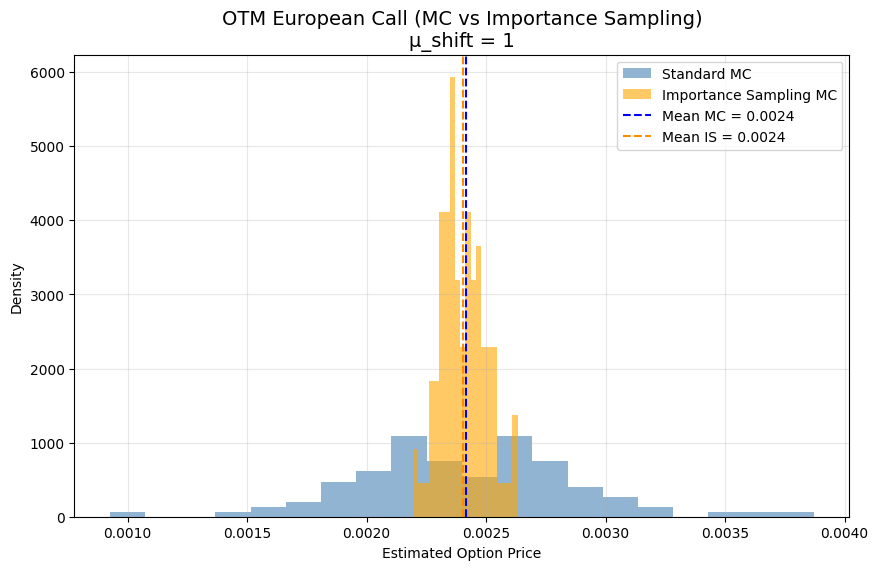

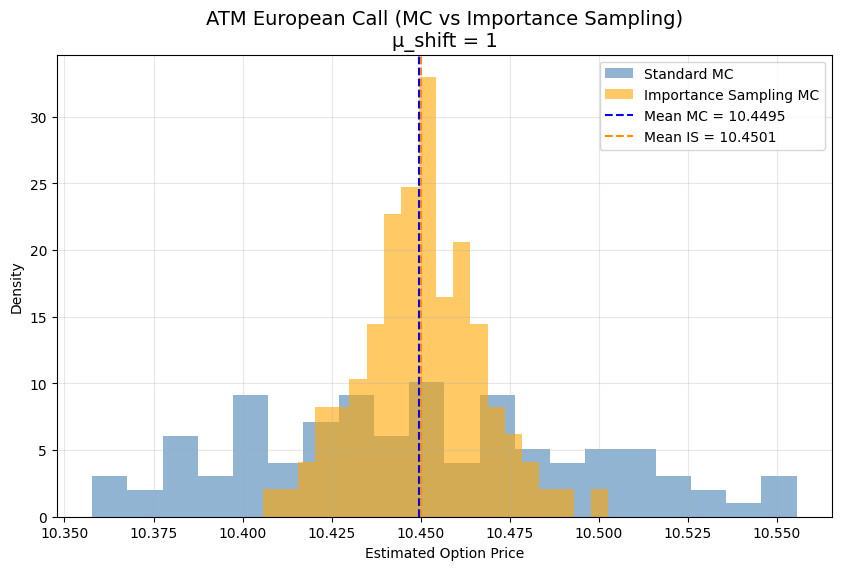

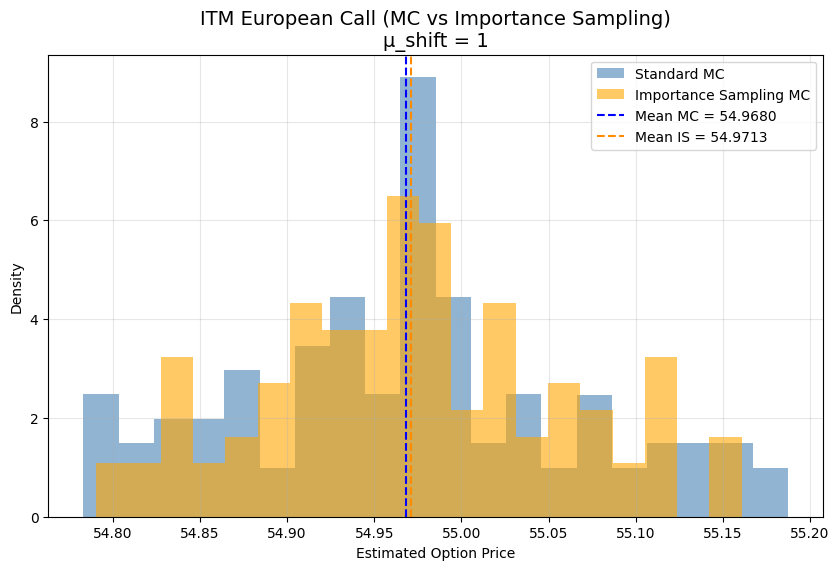

In [61]:
# --- Number of paths ---
n_paths: int = 100_000


# Containers for results
mc_estimates_otm, mc_is_estimates_otm = [], []
mc_estimates_atm, mc_is_estimates_atm = [], []
mc_estimates_itm, mc_is_estimates_itm = [], []

# --- Run all seeds ---
for seed in range(n_runs):
    # --- OTM ---
    mc_estimates_otm.append(european_call_mc(s0_otm, K, r, q, sigma, T, n_paths, seed)[0])
    price_is, _, _ = european_call_mc_is(s0_otm, K, r, q, sigma, T, n_paths, mu_shift, seed)
    mc_is_estimates_otm.append(price_is)

    # --- ATM ---
    mc_estimates_atm.append(european_call_mc(s0_atm, K, r, q, sigma, T, n_paths, seed)[0])
    price_is, _, _ = european_call_mc_is(s0_atm, K, r, q, sigma, T, n_paths, mu_shift, seed)
    mc_is_estimates_atm.append(price_is)

    # --- ITM ---
    mc_estimates_itm.append(european_call_mc(s0_itm, K, r, q, sigma, T, n_paths, seed)[0])
    price_is, _, _ = european_call_mc_is(s0_itm, K, r, q, sigma, T, n_paths, mu_shift, seed)
    mc_is_estimates_itm.append(price_is)

# Convert to arrays
mc_estimates_otm, mc_is_estimates_otm = np.array(mc_estimates_otm), np.array(mc_is_estimates_otm)
mc_estimates_atm, mc_is_estimates_atm = np.array(mc_estimates_atm), np.array(mc_is_estimates_atm)
mc_estimates_itm, mc_is_estimates_itm = np.array(mc_estimates_itm), np.array(mc_is_estimates_itm)

# --- Plot OTM ---
plt.figure(figsize=(10, 6))
plt.hist(mc_estimates_otm, bins=20, alpha=0.6, label="Standard MC", density=True, color="steelblue")
plt.hist(mc_is_estimates_otm, bins=20, alpha=0.6, label="Importance Sampling MC", density=True, color="orange")
plt.axvline(np.mean(mc_estimates_otm), color="blue", linestyle="--", label=f"Mean MC = {np.mean(mc_estimates_otm):.4f}")
plt.axvline(np.mean(mc_is_estimates_otm), color="darkorange", linestyle="--", label=f"Mean IS = {np.mean(mc_is_estimates_otm):.4f}")
plt.title(f"OTM European Call (MC vs Importance Sampling)\nμ_shift = {mu_shift}", fontsize=14)
plt.xlabel("Estimated Option Price")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Plot ATM ---
plt.figure(figsize=(10, 6))
plt.hist(mc_estimates_atm, bins=20, alpha=0.6, label="Standard MC", density=True, color="steelblue")
plt.hist(mc_is_estimates_atm, bins=20, alpha=0.6, label="Importance Sampling MC", density=True, color="orange")
plt.axvline(np.mean(mc_estimates_atm), color="blue", linestyle="--", label=f"Mean MC = {np.mean(mc_estimates_atm):.4f}")
plt.axvline(np.mean(mc_is_estimates_atm), color="darkorange", linestyle="--", label=f"Mean IS = {np.mean(mc_is_estimates_atm):.4f}")
plt.title(f"ATM European Call (MC vs Importance Sampling)\nμ_shift = {mu_shift}", fontsize=14)
plt.xlabel("Estimated Option Price")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# --- Plot ITM ---
plt.figure(figsize=(10, 6))
plt.hist(mc_estimates_itm, bins=20, alpha=0.6, label="Standard MC", density=True, color="steelblue")
plt.hist(mc_is_estimates_itm, bins=20, alpha=0.6, label="Importance Sampling MC", density=True, color="orange")
plt.axvline(np.mean(mc_estimates_itm), color="blue", linestyle="--", label=f"Mean MC = {np.mean(mc_estimates_itm):.4f}")
plt.axvline(np.mean(mc_is_estimates_itm), color="darkorange", linestyle="--", label=f"Mean IS = {np.mean(mc_is_estimates_itm):.4f}")
plt.title(f"ITM European Call (MC vs Importance Sampling)\nμ_shift = {mu_shift}", fontsize=14)
plt.xlabel("Estimated Option Price")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

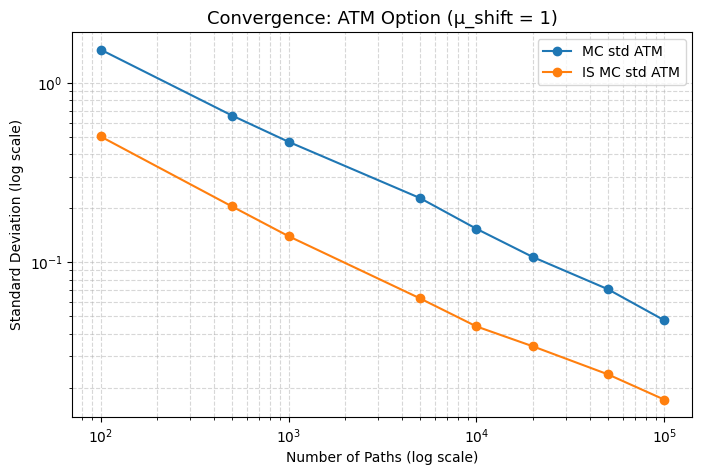

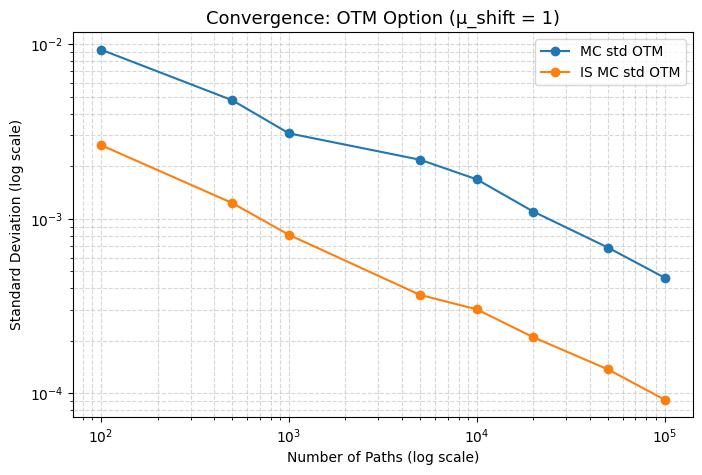

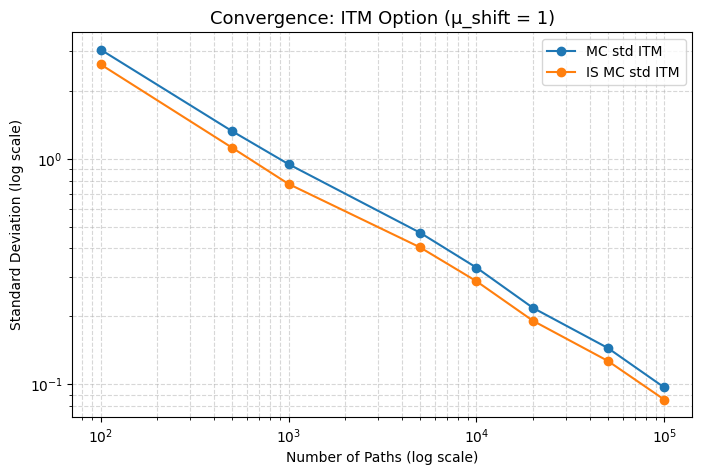

In [62]:
path_list = [100, 500, 1000, 5000, 10000, 20000, 50000, 100000]

# Store stds for each moneyness
mc_std_otm, mc_is_std_otm = [], []
mc_std_atm, mc_is_std_atm = [], []
mc_std_itm, mc_is_std_itm = [], []

# --- Loop across path sizes ---
for n_paths in path_list:
    seeds = np.arange(n_runs)

    # --- OTM ---
    mc_estimates_otm, mc_is_estimates_otm = [], []
    for seed in seeds:
        mc_estimates_otm.append(european_call_mc(s0_otm, K, r, q, sigma, T, n_paths, seed)[0])
        price_is, _, _ = european_call_mc_is(s0_otm, K, r, q, sigma, T, n_paths, mu_shift, seed)
        mc_is_estimates_otm.append(price_is)
    mc_std_otm.append(np.std(mc_estimates_otm))
    mc_is_std_otm.append(np.std(mc_is_estimates_otm))

    # --- ATM ---
    mc_estimates_atm, mc_is_estimates_atm = [], []
    for seed in seeds:
        mc_estimates_atm.append(european_call_mc(s0_atm, K, r, q, sigma, T, n_paths, seed)[0])
        price_is, _, _ = european_call_mc_is(s0_atm, K, r, q, sigma, T, n_paths, mu_shift, seed)
        mc_is_estimates_atm.append(price_is)
    mc_std_atm.append(np.std(mc_estimates_atm))
    mc_is_std_atm.append(np.std(mc_is_estimates_atm))

    # --- ITM ---
    mc_estimates_itm, mc_is_estimates_itm = [], []
    for seed in seeds:
        mc_estimates_itm.append(european_call_mc(s0_itm, K, r, q, sigma, T, n_paths, seed)[0])
        price_is, _, _ = european_call_mc_is(s0_itm, K, r, q, sigma, T, n_paths, mu_shift, seed)
        mc_is_estimates_itm.append(price_is)
    mc_std_itm.append(np.std(mc_estimates_itm))
    mc_is_std_itm.append(np.std(mc_is_estimates_itm))

# --- Plot for ATM ---
plt.figure(figsize=(8, 5))
plt.plot(path_list, mc_std_atm, marker="o", label="MC std ATM")
plt.plot(path_list, mc_is_std_atm, marker="o", label="IS MC std ATM")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Paths (log scale)")
plt.ylabel("Standard Deviation (log scale)")
plt.title(f"Convergence: ATM Option (μ_shift = {mu_shift})", fontsize=13)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot for OTM ---
plt.figure(figsize=(8, 5))
plt.plot(path_list, mc_std_otm, marker="o", label="MC std OTM")
plt.plot(path_list, mc_is_std_otm, marker="o", label="IS MC std OTM")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Paths (log scale)")
plt.ylabel("Standard Deviation (log scale)")
plt.title(f"Convergence: OTM Option (μ_shift = {mu_shift})", fontsize=13)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# --- Plot for ITM ---
plt.figure(figsize=(8, 5))
plt.plot(path_list, mc_std_itm, marker="o", label="MC std ITM")
plt.plot(path_list, mc_is_std_itm, marker="o", label="IS MC std ITM")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of Paths (log scale)")
plt.ylabel("Standard Deviation (log scale)")
plt.title(f"Convergence: ITM Option (μ_shift = {mu_shift})", fontsize=13)
plt.legend()
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()
